# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [26]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Lasso

%matplotlib inline

Прочитаем исходные данные:

In [27]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.


    ВЫВОДЫ ПО РАЗВЕДЫВАТЕЛЬНОМУ АНАЛИЗУ ДАННЫХ:
    
    1) Распределение признаков 'Por', 'AI', 'VR' похоже на нормальное, а признаков 'Perm', 'Brittle', 'TOC' - на логнормальное;
    2) Видна прямая линейная регрессионная связь между целевой переменной и признаками: 'Por', 'Perm' и 'TOC' (признаки ранжированы по убыванию силы линейной связи);
    3) Признаки 'Perm', 'AI' и 'VR' содержат выбросы



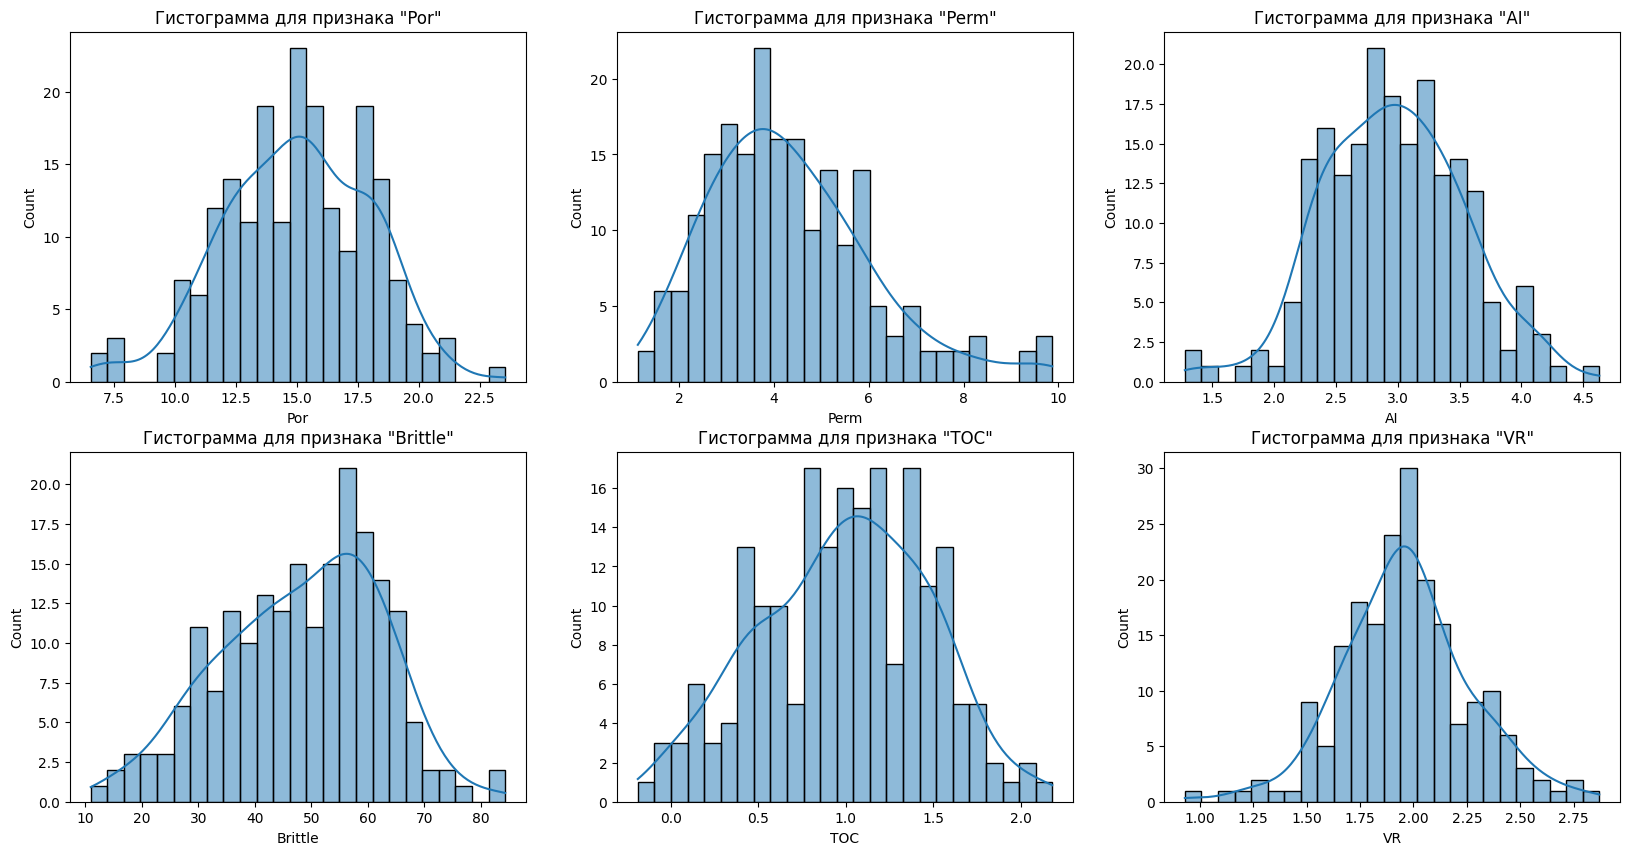

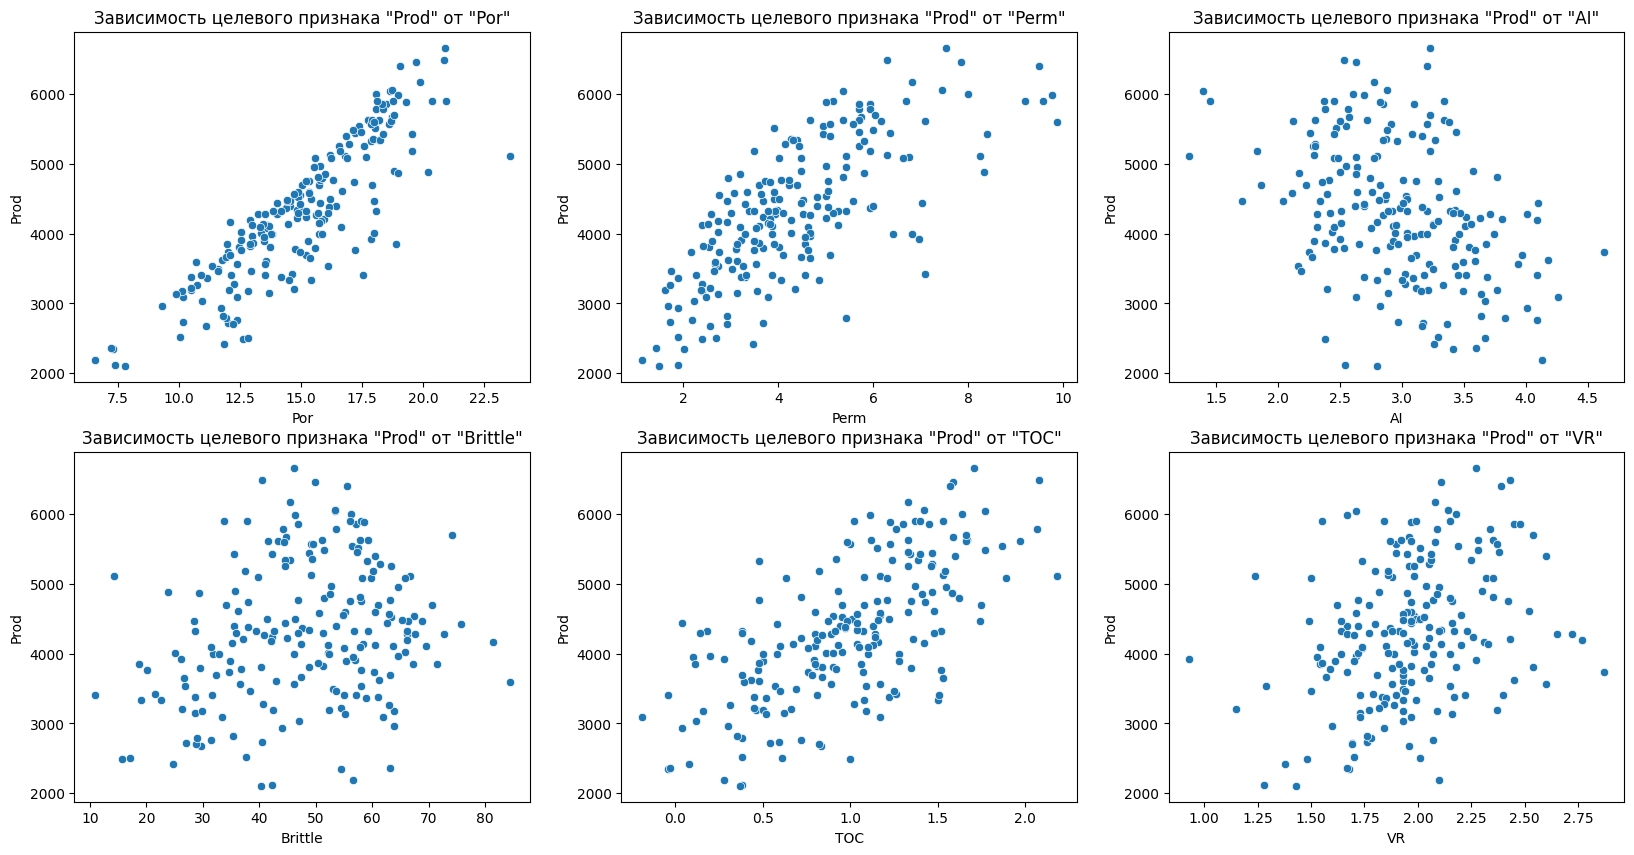

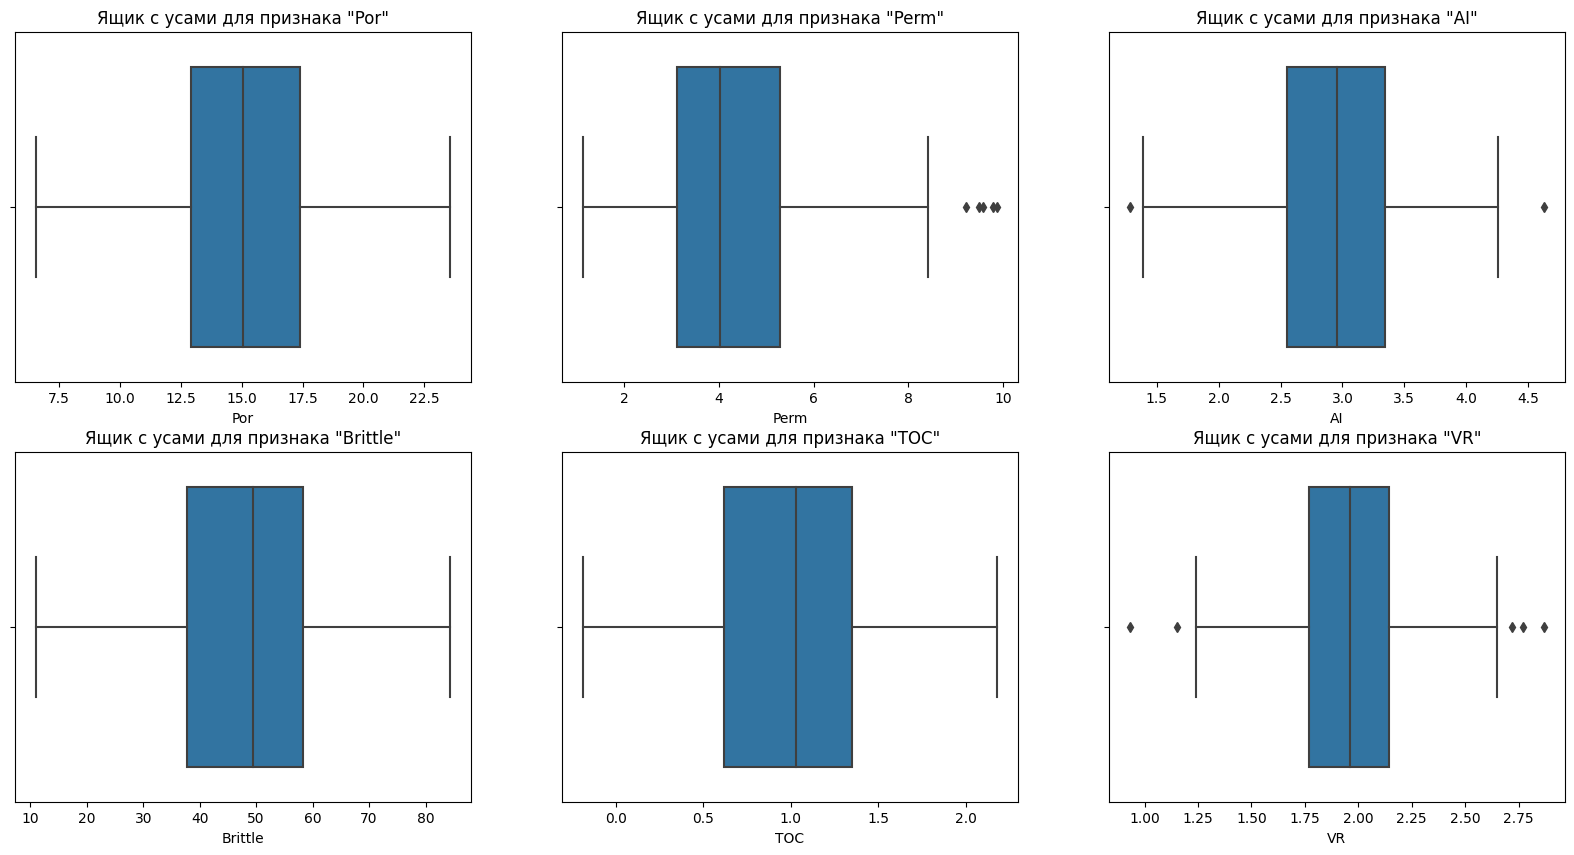

In [28]:
columns = data.columns.drop(['Well', 'Prod'])

fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for n, column in enumerate(columns):
    sns.histplot(
        data=data,
        x=column,
        bins=25,
        kde=True,
        ax=ax[n // 3][n % 3])
    ax[n // 3][n % 3].set_title('Гистограмма для признака "{}"'.format(column))
    
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for n, column in enumerate(columns):
    sns.scatterplot(
        data=data,
        x=column,
        y='Prod',
        ax=ax[n // 3][n % 3]
    )
    ax[n // 3][n % 3].set_title('Зависимость целевого признака "Prod" от "{}"'.format(column))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for n, column in enumerate(columns):
    sns.boxplot(
        data=data,
        x=column,
        orient='h',
        ax=ax[n // 3][n % 3]
    )
    ax[n // 3][n % 3].set_title('Ящик с усами для признака "{}"'.format(column))
conclusion = """
    ВЫВОДЫ ПО РАЗВЕДЫВАТЕЛЬНОМУ АНАЛИЗУ ДАННЫХ:
    
    1) Распределение признаков 'Por', 'AI', 'VR' похоже на нормальное, а признаков 'Perm', 'Brittle', 'TOC' - на логнормальное;
    2) Видна прямая линейная регрессионная связь между целевой переменной и признаками: 'Por', 'Perm' и 'TOC' (признаки ранжированы по убыванию силы линейной связи);
    3) Признаки 'Perm', 'AI' и 'VR' содержат выбросы
"""
print(conclusion)
    

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

rank(G)=8
det(G)=0.0007


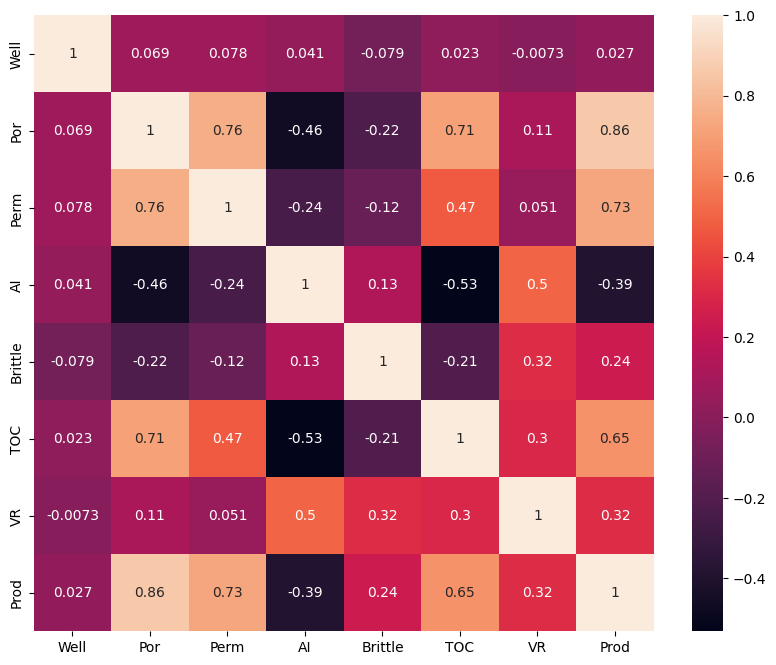

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
# Визуализируем матрицу корреляций, удалив ненужный признак номера скважины 'Well'
sns.heatmap(data=data.corr(), annot=True, ax=ax)
G = data.corr().values
print('rank(G)={}'.format(np.linalg.matrix_rank(G)))
print('det(G)={}'.format(round(np.linalg.det(G), 4)))

## Выводы:
1) Факторы, коррелирующие больше всего с целевой переменной: 'Por', 'Perm', 'TOC';<br><br>
2) Матрица корреляций является плохо обусловленной, так как ее определитель близок к нулю;<br><br>
3) Чистой коллинеарности нет, так как ранг матроицы корреляций максимален (т.е. все признаки линейно независимы), но матрица вырождена, что говорит о наличие мультиколлинеарности;<br><br>
4) Классическую линейную регрессию использовать можно (мы получим весовые коэффициенты, но они будут очень большие по модулю и мы не сможем их интерпретировать).

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [30]:
X = data.drop('Prod', axis=1)
y = data['Prod']
# Вычислим OLS-оценку для коэффициентов
A = pd.DataFrame(np.ones(X.shape[0]), columns=['Ones'])
for column in X.columns:
    A[column] = X[column]
    

  
w_hat = np.linalg.inv(A.T@A)@A.T@y

# Представим результаты в виде структуры 'DataFrame'
columns = list(data.drop('Prod', axis=1))
columns.insert(0, 'intercept')
df_coef = pd.DataFrame(columns, columns=['Факторы'])
df_coef['Веса'] = np.round(w_hat)
df_coef

,Факторы,Веса
0,intercept,-1232.0
1,Well,0.0
2,Por,230.0
3,Perm,116.0
4,AI,-365.0
5,Brittle,25.0
6,TOC,-78.0
7,VR,785.0


## Выводы:
1) Неинформативным является признак 'Well', так как он не несет никакой статистически значимой нагрузки;<br><br>
2) Интерпретация коэффициентов:<br><br>
    a) Увеличение пористости скважины (Por) на 1% увеличивает добычу газа на 230 млн. куб. футов;<br><br>
    б) Увеличение проницаемости скважина (Perm) на 1 единицу увеличивает добычу газа в сутки на 116 млн. куб. футов;<br><br>
    в) Увеличение акустического импеданса (AI) на 1 млн. кг на кв. м уменьшает добычу газа в сутки на 365 млн. куб. футов; 

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [31]:
# Вектор признаков предсказания
feature_vector = np.array([1, 106, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42])
forecast_result = np.dot(w_hat, feature_vector)
print('Средняя абсолютная ошибка предсказания для скважины №106:', abs(round(forecast_result-4748.315024)))
ones = np.ones(X.shape[0])
ones = np.reshape(ones, (X.shape[0], 1))
A = np.column_stack((ones, X))
# Применим тензорное произведение,чтобы найти предсказания для всего набора данных X
y_pred = A@w_hat
print('MAPE is', round(mean_absolute_percentage_error(y, y_pred)*100, 1), '%')
OLS_classic_without_features_selection = round(mean_absolute_percentage_error(y, y_pred)*100, 1)


Средняя абсолютная ошибка предсказания для скважины №106: 25
MAPE is 3.6 %


## Выводы:
1) Получили небольшую среднюю ошибку одиночного предсказания;<br><br>
2) Процент абсолютной ошибки в процентах составил 3.6% что не так уж и много;<br><br>
3) Классическая модель линейной регресси по МНК  оказалась приемлемого качества и это несмотря на присутствие мультиколлинеарности и вырожденности матрицы корреляций, что говорит о том, что ее можно сделать еще лучше если все это устранить

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

,Факторы,Веса
0,intercept,-1232.0
1,Well,0.0
2,Por,230.0
3,Perm,116.0
4,AI,-365.0
5,Brittle,25.0
6,TOC,-78.0
7,VR,785.0


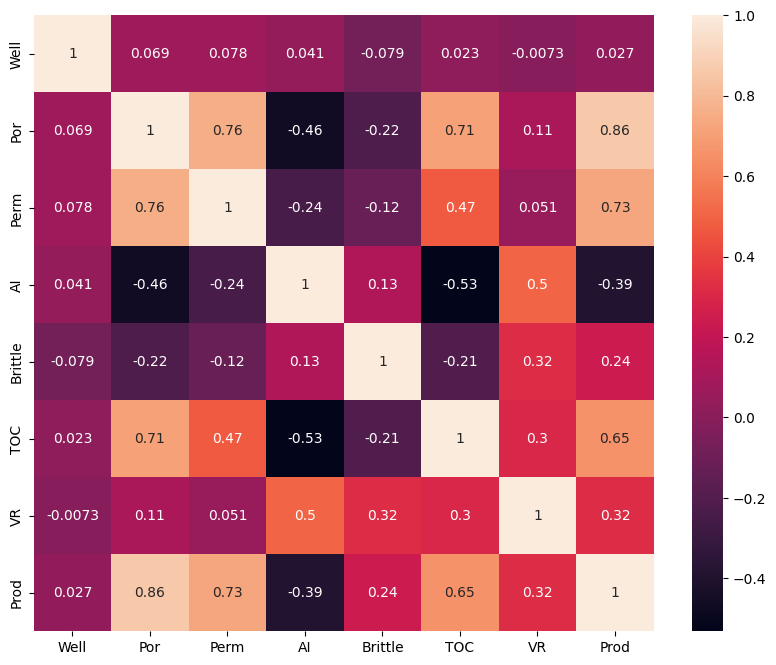

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
# Визуализируем матрицу корреляций, удалив ненужный признак номера скважины 'Well'
sns.heatmap(data=data.corr(), annot=True, ax=ax)

df_coef

## Выводы:
1) Коэффициент корреляции между целевым признаком и признаком 'TOC' равен 0.65, что говорит о прямой зависимости, а вес коэффициента при 'TOC' в уравнении линейной регрессии равен -78, что говорит об обратной зависимости с целевым признаком. Получаем противоречие;<br><br>
2) Данное противоречие связано с присутствием мультиколлинеарности в данных

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [33]:
X = data.drop('Prod', axis=1)
y = data['Prod']
X = X.drop(['Well', 'Perm', 'TOC'], axis=1)
# Вычислим OLS-оценку для коэффициентов
A = pd.DataFrame(np.ones(X.shape[0]), columns=['Ones'])
for column in X.columns:
    A[column] = X[column]
  
w_hat = np.linalg.inv(A.T@A)@A.T@y

# Представим результаты в виде структуры 'DataFrame'
columns = list(X.columns)
columns.insert(0, 'intercept')
df_coef = pd.DataFrame(columns, columns=['Факторы'])
df_coef['Веса'] = np.round(w_hat)
display(df_coef)

ones = np.ones(X.shape[0])
ones = np.reshape(ones, (X.shape[0], 1))
A = np.column_stack((ones, X))
# Применим тензорное произведение,чтобы найти предсказания для всего набора данных X
y_pred = A@w_hat
print('MAPE is', round(mean_absolute_percentage_error(y, y_pred)*100, 1), '%')
OLS_classic_with_features_selection = round(mean_absolute_percentage_error(y, y_pred)*100, 1)

,Факторы,Веса
0,intercept,-1835.0
1,Por,293.0
2,AI,-200.0
3,Brittle,28.0
4,VR,517.0


MAPE is 4.0 %


## Выводы:
1) Интерпретация коэффициентов:<br><br>
    a) Увеличение пористости скважины (Por) на 1% увеличивает добычу газа на 293 (старое значение 230, вес возрос) млн. куб. футов;<br><br> 
    б) Увеличение акустического импеданса (AI) на 1 млн. кг на кв. м уменьшает добычу газа в сутки на 200 (старое значение 365, вес коэффициента уменьшился по модулю) млн. куб. футов;<br><br>
2) Качество модели по метрике MAPE 4% (старое значение 3.6%). Качество моделирования упало;<br><br>
3) Противеречие между коэффициентами корреляции и коэффициентами линейной регрессии удалось побороть.


### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [34]:
lm = LinearRegression()
lm.fit(X, y)
y_pred = lm.predict(X)

# Представим результаты в виде структуры 'DataFrame'
columns = list(X.columns)
columns.insert(0, 'intercept')
df_coef = pd.DataFrame(columns, columns=['Факторы'])
df_coef['Веса'] = np.round(w_hat)
display(df_coef)
print('MAPE is', round(mean_absolute_percentage_error(y, y_pred)*100, 1), '%')
lr_from_sklearn = round(mean_absolute_percentage_error(y, y_pred)*100, 1)

,Факторы,Веса
0,intercept,-1835.0
1,Por,293.0
2,AI,-200.0
3,Brittle,28.0
4,VR,517.0


MAPE is 4.0 %


## Выводы:
1) Коэффициенты линейной регрессии аналогичны полученным ранее;<br><br>
2) Значение метрики MAPE равно значению, полученному ранее.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [35]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [36]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_scaled_poly = poly.fit_transform(X)
print('The number of features of our data after the polinomial transformation is {}'.format(X_scaled_poly.shape[1]))
lr = LinearRegression()
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lr,
                            X_scaled_poly,
                            y,
                            scoring='neg_mean_absolute_percentage_error',
                            cv=5,
                            return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f}%'.format(-cv_results['train_score'].mean()*100))
print('MAPE на валидационных фолдах: {:.2f}%'.format(-cv_results['test_score'].mean()*100))
poly_sklearn_without_regularization_test = -cv_results['test_score'].mean()*100
poly_sklearn_without_regularization_train = -cv_results['train_score'].mean()*100


The number of features of our data after the polinomial transformation is 34
MAPE на тренировочных фолдах: 1.77%
MAPE на валидационных фолдах: 2.68%


## Выводы:
1) Как и следовало ожидать метрика MAPE на тненировочных фолдах лучше, чем на валидационных;<br><br>
2) На полиномиальных признаках нам удалось понизить метрику с 4% до 2.68%

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [37]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_scaled_poly = poly.fit_transform(X)

param_grid = [
    {'alpha': list(np.linspace(0.01, 1, 20, dtype=float))}
]

grid_search = GridSearchCV(
    estimator=Lasso(max_iter=10000, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
    cv=5,n_jobs=-1
);

grid_search.fit(X_scaled_poly, y)
print('MAPE на валидационных фолдах: {:.2f}%'.format(-grid_search.cv_results_['mean_test_score'].mean()*100))
print('MAPE на тренировочных фолдах: {:.2f}%'.format(-grid_search.cv_results_['mean_train_score'].mean()*100))
print('Best params: ', grid_search.best_params_)
poly_sklearn_with_lasso_regularization_test = -grid_search.cv_results_['mean_test_score'].mean()*100
poly_sklearn_with_lasso_regularization_train = -grid_search.cv_results_['mean_train_score'].mean()*100
poly_sklearn_with_lasso_regularization_best_params = grid_search.best_params_



/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.377e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.424e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.27

/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.614e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.285e+05, tolerance: 1.474e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.36

MAPE на валидационных фолдах: 2.40%
MAPE на тренировочных фолдах: 1.85%
Best params:  {'alpha': 1.0}


/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e+06, tolerance: 1.958e+04
  model = cd_fast.enet_coordinate_descent(


## Вывод:
Метрика MAPE на валидационных фолдах немного улучшилась

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [38]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_scaled_poly = poly.fit_transform(X)

param_grid = [
    {'alpha': list(np.linspace(0.01, 1, 20, dtype=float))}
]

grid_search = GridSearchCV(
    estimator=Ridge(max_iter=10000, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
    cv=5,n_jobs=-1
);

grid_search.fit(X_scaled_poly, y)
print('MAPE на валидационных фолдах: {:.2f}%'.format(-grid_search.cv_results_['mean_test_score'].mean()*100))
print('MAPE на тренировочных фолдах: {:.2f}%'.format(-grid_search.cv_results_['mean_train_score'].mean()*100))
print('Best params: ', grid_search.best_params_)
poly_sklearn_with_ridge_regularization_test = -grid_search.cv_results_['mean_test_score'].mean()*100
poly_sklearn_with_ridge_regularization_train = -grid_search.cv_results_['mean_train_score'].mean()*100
poly_sklearn_with_ridge_regularization_best_params = grid_search.best_params_




MAPE на валидационных фолдах: 2.55%
MAPE на тренировочных фолдах: 1.82%
Best params:  {'alpha': 1.0}


## Выводы:
Метрика MAPE на валидационных фолдах с применением Ridge-регуляризации немного хуже, чем с применением Lasso-регуляризации

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [39]:

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_scaled_poly = poly.fit_transform(X)

param_grid = [
    {'alpha': list(np.linspace(0.01, 1, 20, dtype=float)),
     'l1_ratio': list(np.linspace(0.01, 1, 20, dtype=float))}
]

grid_search = GridSearchCV(
    estimator=ElasticNet(max_iter=10000, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
    cv=5,n_jobs=-1
);

grid_search.fit(X_scaled_poly, y)
print('MAPE на валидационных фолдах: {:.2f}%'.format(-grid_search.cv_results_['mean_test_score'].mean()*100))
print('MAPE на тренировочных фолдах: {:.2f}%'.format(-grid_search.cv_results_['mean_train_score'].mean()*100))
print('Best params: ', grid_search.best_params_)
poly_sklearn_with_elasticnet_regularization_test = -grid_search.cv_results_['mean_test_score'].mean()*100
poly_sklearn_with_elastic_regularization_train = -grid_search.cv_results_['mean_train_score'].mean()*100
poly_sklearn_with_elastic_regularization_best_params = grid_search.best_params_


/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.460e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.587e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.23

/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.576e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.230e+05, tolerance: 1.582e+04
  model = cd_fast.enet_coordinate_descent(
/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.47

MAPE на валидационных фолдах: 2.37%
MAPE на тренировочных фолдах: 1.89%
Best params:  {'alpha': 0.7394736842105263, 'l1_ratio': 0.8436842105263158}


/home/flate/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+06, tolerance: 1.958e+04
  model = cd_fast.enet_coordinate_descent(


# Вывод:
Полиномиальная регрессия c применением ElasticNet-регуляризации дает наилучший результат по метрике MAPE

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [41]:
pv_table = pd.DataFrame(
    data=[
            ['OLS_classic_without_features_selection', '', 'False', OLS_classic_without_features_selection],
            ['OLS_classic_with_features_selection', '', 'False', OLS_classic_with_features_selection],
            ['linear_regression_from_sklearn', '', 'False', lr_from_sklearn],
            ['sklearn_poly_regression_without_regularization', '', 'True', poly_sklearn_without_regularization_train, poly_sklearn_without_regularization_test],
            ['sklearn_poly_regression_with_lasso_regularization', poly_sklearn_with_lasso_regularization_best_params, 'True', poly_sklearn_with_lasso_regularization_train, poly_sklearn_with_lasso_regularization_test],
            ['sklearn_poly_regression_with_ridge_regularization', poly_sklearn_with_ridge_regularization_best_params, 'True', poly_sklearn_with_ridge_regularization_train, poly_sklearn_with_ridge_regularization_test],
            ['sklearn_poly_regression_with_elasticnet_regularization', poly_sklearn_with_elastic_regularization_best_params, 'True', poly_sklearn_with_elastic_regularization_train, poly_sklearn_with_elasticnet_regularization_test]
        ],
    columns=['Type of model', 'Hyperparameters', 'Poly_Features', 'MAPE on training folds', 'MAPE on validation folds']
)
pv_table

,Type of model,Hyperparameters,Poly_Features,MAPE on training folds,MAPE on validation folds
0,OLS_classic_without_features_selection,,False,3.600000,NaN
1,OLS_classic_with_features_selection,,False,4.000000,NaN
2,linear_regression_from_sklearn,,False,4.000000,NaN
3,sklearn_poly_regression_without_regularization,,True,1.773240,2.680875
4,sklearn_poly_regression_with_lasso_regularization,{'alpha': 1.0},True,1.850207,2.403585
5,sklearn_poly_regression_with_ridge_regularization,{'alpha': 1.0},True,1.819076,2.546454
6,sklearn_poly_regression_with_elasticnet_regula...,"{'alpha': 0.7394736842105263, 'l1_ratio': 0.84...",True,1.886046,2.371454


## Вывод:
Наилучший результат показывает полиномиальная регрессия с использованием ElasticNet-регуляризации